In [1]:
import os
import importlib
import time

import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import skimage
from skimage import transform as skimg_transform
#from skimage import io as img_io
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, utils
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import load_data
import model
import warnings

In [2]:
plt.style.use('Solarize_Light2')
warnings.filterwarnings('ignore')
%matplotlib inline
importlib.reload(load_data)
importlib.reload(model)

<module 'model' from '/home/uldo/work/kaggle/competitions/Humpback_Whale_Identification/code/model.py'>

In [3]:
BATCH_SIZE = 40

In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        orig_height, orig_width = image.shape[:2]
        if isinstance(self.output_size, int):
            if orig_height > orig_width:
                new_height, new_width = self.output_size * orig_height / orig_width, self.output_size
            else:
                new_height, new_width = self.output_size, self.output_size * orig_width / orig_height
        else:
            new_height, new_width = self.output_size

        new_height, new_width = int(new_height), int(new_width)

        img = skimg_transform.resize(image, (new_height, new_width))

        return {'image': img, 'label': label}

In [5]:
class UnifyRescale(object):
    
    def __init__(self, output_size=128):
        assert isinstance(output_size, int)
        self.output_size = output_size
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        img = skimg_transform.resize(image, (self.output_size, self.output_size))

        return {'image': img, 'label': label}

In [6]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        orig_height, orig_width = image.shape[:2]
        new_height, new_width = self.output_size

        top = np.random.randint(0, orig_height - new_height)
        left = np.random.randint(0, orig_width - new_width)

        image = image[top: top + new_height, left: left + new_width]

        return {'image': image, 'label': label}

In [7]:
class ToTensor(object):
    
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, image_size=128):
        self.image_size = image_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        
        """ The original code didn't expect gray scale images """
        print("image.shape: ", image.shape)
        
        gray_scale_image = torch.zeros(
            [self.image_size, self.image_size]
        ).shape == image.shape
        if gray_scale_image:
            image = np.stack((image,) * 3, axis=-1)
        
        image = image.transpose((2, 0, 1))
        #print("image.shape: ", image.shape)
        #print("label: ", label)
        return {'image': torch.from_numpy(image), 'label': torch.tensor(label, dtype=torch.uint8)}

In [8]:
def show_whale_batch(sample_batched):
    """Show whales for a batch of samples."""
    images_batch = sample_batched['image']
    labels_batch = sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.title('Batch from dataloader')

In [9]:
def prepare_loaders(dataset, valid_train_ratio=0.6):
    dataset_size = len(dataset)
    print("dataset_size: ", dataset_size)

    validation_subset_size = int(dataset_size * (1 - valid_train_ratio))
    print("validation_subset_size: ", validation_subset_size)

    indices = list(range(dataset_size))
    validation_indices = np.random.choice(indices, size=validation_subset_size, replace=False)
    train_indices = list(set(indices) - set(validation_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(validation_indices)
    
    dataset_sizes = {
            'train': len(train_indices),
            'validation': len(validation_indices)
        }

    train_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=train_sampler)
    validation_loader = data.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=1, sampler=validation_sampler)

    loaders = {
            'train': train_loader,
            'validation': validation_loader
        }

    return loaders, dataset_sizes

In [10]:
train_df = load_data.load_text_data('../input/train.csv')

In [11]:
image_size = 128
dataset = load_data.HumpbackWhalesDataset(
    train_df,
    #transform=load_data.transforms.ToTensor()
    #transform=ToTensor()
    transform=transforms.Compose(
        [
            #Rescale(int(image_size*1.25)),
            Rescale(int(image_size)),
            #RandomCrop(image_size),
            UnifyRescale(int(image_size)),
            ToTensor()
        ]
    )
)

In [12]:
dataset_loaders, dataset_sizes = prepare_loaders(dataset)

dataset_size:  25361
validation_subset_size:  10144


In [13]:
train_loader = dataset_loaders['train']
validation_loader = dataset_loaders['validation']
train_dataset_size = dataset_sizes['train']

validation_dataset_size = dataset_sizes['validation']

In [14]:
print(train_dataset_size)
print(validation_dataset_size)

15217
10144


In [15]:
print(train_loader)

In [16]:
train_iter = iter(train_loader)

image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128)
image.shape:  (128, 128)
image.shape:  (128, 128, 3)
image.shape:  (128, 128)
image.shape:  (128, 128, 3)
image.shape:  (128, 128)
image.shape:  (128, 128, 3)
image.shape:  (128, 128)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128)
image.shape:  (128,

In [17]:
print(type(train_iter))

<class 'torch.utils.data.dataloader._DataLoaderIter'>


In [18]:
images, labels = train_iter.next()

image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128)
image.shape:  (128, 128)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
imag

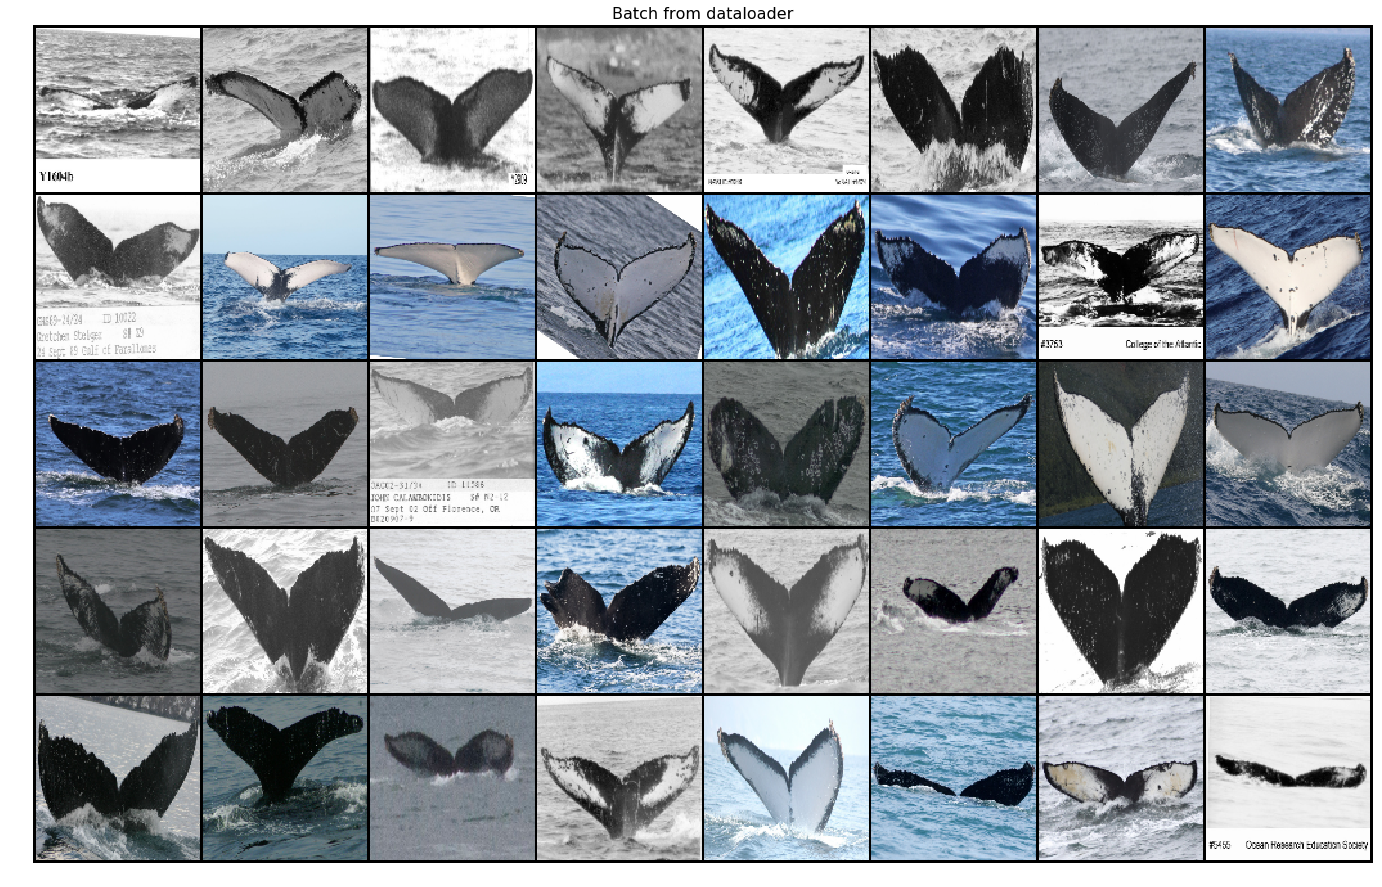

image.shape:  (128, 128)
image.shape:  (128, 128)
image.shape:  (128, 128)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128, 3)
image.shape:  (128, 128)


In [19]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['label'])
    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure(figsize=(24, 24))
        show_whale_batch(sample_batched)
        plt.axis('off')
        #plt.ioff()
        plt.show()
        break